In [5]:
# Imports here
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter 
import csv

from PIL import Image
import json
from matplotlib.ticker import FormatStrFormatter

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [7]:
data_dir = './dataset'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [8]:
# Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

In [9]:
trainset = torchvision.datasets.ImageFolder(root=train_dir, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0)

testset = torchvision.datasets.ImageFolder(root=valid_dir, transform=test_transforms)
validloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=0)

In [10]:
class EpisodicDataLoader(torch.utils.data.DataLoader):
   def __init__(self, dataset, n_support, n_query, n_episodes, *args, **kwargs):
       super(EpisodicDataLoader, self).__init__(dataset, *args, **kwargs)
       self.n_support = n_support
       self.n_query = n_query
       self.n_episodes = n_episodes

   def __iter__(self):
       for _ in range(self.n_episodes):
           support_set = []
           query_set = []
           for class_idx in range(self.dataset.num_classes):
               data = self.dataset.get_class_data(class_idx)
               indices = torch.randperm(len(data))
               support_idx = indices[:self.n_support]
               query_idx = indices[self.n_support:self.n_support+self.n_query]
               support_set.append(data[support_idx])
               query_set.append(data[query_idx])
           yield torch.stack(support_set), torch.stack(query_set)

In [11]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 56 * 56, 512)  # Adjusted this line
        self.fc2 = nn.Linear(512, 102)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [12]:
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Change to Adam optimizer

In [13]:
num_epochs = 2
csv_filename = "few_shot_learning_metrics.csv"

# Initialize lists to store losses and accuracies
train_losses = []
valid_losses = []
accuracies = []

writer = SummaryWriter()

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (support_set, query_set) in enumerate(trainloader):
        optimizer.zero_grad()
        support_set, query_set = support_set.to(device), query_set.to(device)
        embeddings = model(support_set)
        loss = criterion(embeddings, query_set)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], Loss: {loss.item()}')

    # Calculate average training loss for this epoch
    epoch_train_loss = running_loss / len(trainloader)

    # Validate the model and calculate validation loss and accuracy
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for support_set, query_set in validloader:
            support_set, query_set = support_set.to(device), query_set.to(device)
            embeddings = model(support_set)
            loss = criterion(embeddings, query_set)
            valid_loss += loss.item()
            _, predicted = torch.max(embeddings, 1)
            total += query_set.size(0)
            correct += (predicted == query_set).sum().item()

    epoch_valid_loss = valid_loss / len(validloader)
    accuracy = 100 * correct / total

    print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_valid_loss:.4f}, Accuracy: {accuracy:.2f}%')

    # Log metrics to TensorBoard
    writer.add_scalar('Loss/Training', epoch_train_loss, epoch)
    writer.add_scalar('Loss/Validation', epoch_valid_loss, epoch)
    writer.add_scalar('Accuracy/Validation', accuracy, epoch)
    # Inside the training loop
# ...

# After logging to TensorBoard, write metrics to the CSV file
    with open(csv_filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch, epoch_train_loss, epoch_valid_loss, accuracy])

    # Store losses and accuracies in the lists
    train_losses.append(epoch_train_loss)
    valid_losses.append(epoch_valid_loss)
    accuracies.append(accuracy)

# Plot losses and accuracies

Epoch [1/2], Step [10/103], Loss: 4.617878437042236
Epoch [1/2], Step [20/103], Loss: 4.289416790008545
Epoch [1/2], Step [30/103], Loss: 4.063996315002441
Epoch [1/2], Step [40/103], Loss: 4.023040294647217
Epoch [1/2], Step [50/103], Loss: 4.1343302726745605
Epoch [1/2], Step [60/103], Loss: 3.743927001953125
Epoch [1/2], Step [70/103], Loss: 3.7991111278533936
Epoch [1/2], Step [80/103], Loss: 4.029849052429199
Epoch [1/2], Step [90/103], Loss: 3.631598949432373


KeyboardInterrupt: 

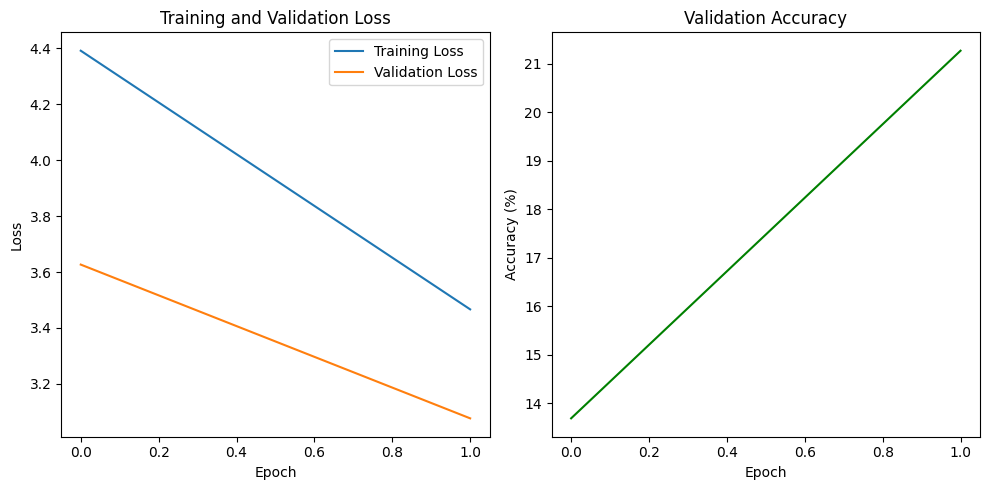

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()


In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
  for support_set, query_set in validloader:
      support_set, query_set = support_set.to(device), query_set.to(device)
      embeddings = model(support_set)
      _, predicted = torch.max(embeddings, 1)
      total += query_set.size(0)
      correct += (predicted == query_set).sum().item()
print('Accuracy: %d %%' % (100 * correct / total))


Accuracy: 21 %


In [ ]:
# Save the trained model to a file
torch.save(model.state_dict(), 'few_shot_learning_model.pth')


In [ ]:
# Create an instance of the CNNModel
model = CNNModel()

# Load the trained model's state dictionary
model.load_state_dict(torch.load('few_shot_learning_model.pth'))

# Switch the model to evaluation mode
model.eval()


CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=401408, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=102, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
)

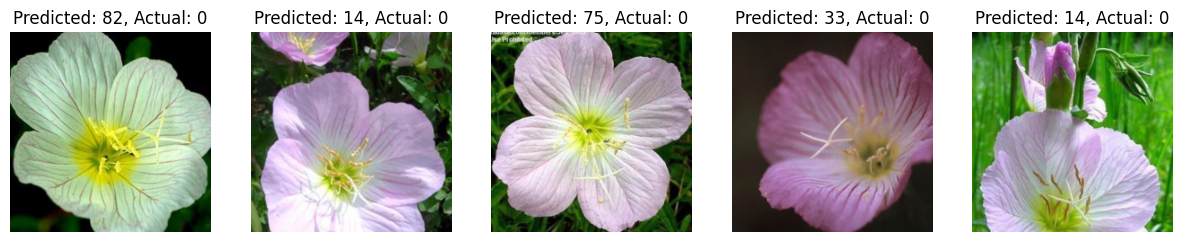

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
model.eval()

# Function to display an image
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    # PyTorch tensors assume the color channel is the first dimension
    image = image.numpy().transpose((1, 2, 0))
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    if title:
        ax.set_title(title)
    return ax

# Function to make predictions and display images
def visualize_predictions(model, dataloader, num_images=5):
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)
    output = model(images)
    _, preds = torch.max(output, 1)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        imshow(images[i], ax=axes[i], title=f'Predicted: {preds[i]}, Actual: {labels[i]}')

# Visualize model predictions on a few validation images
visualize_predictions(model, validloader, num_images=5)


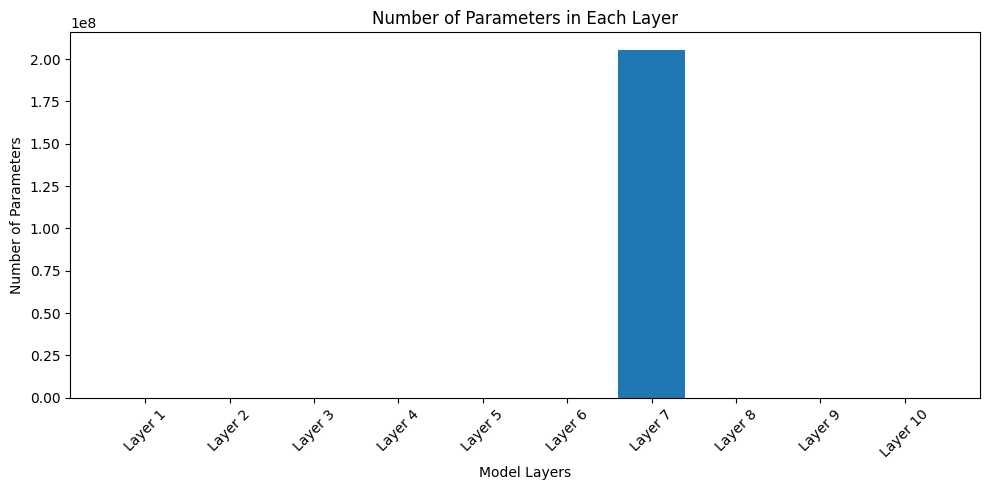

In [ ]:
import matplotlib.pyplot as plt

# Get the model's parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = [p.numel() for p in model_parameters]

# Create labels for each layer
layer_labels = [f'Layer {i}' for i in range(1, len(params) + 1)]

# Create a bar graph
plt.figure(figsize=(10, 5))
plt.bar(layer_labels, params)
plt.xlabel('Model Layers')
plt.ylabel('Number of Parameters')
plt.title('Number of Parameters in Each Layer')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the graph
plt.show()


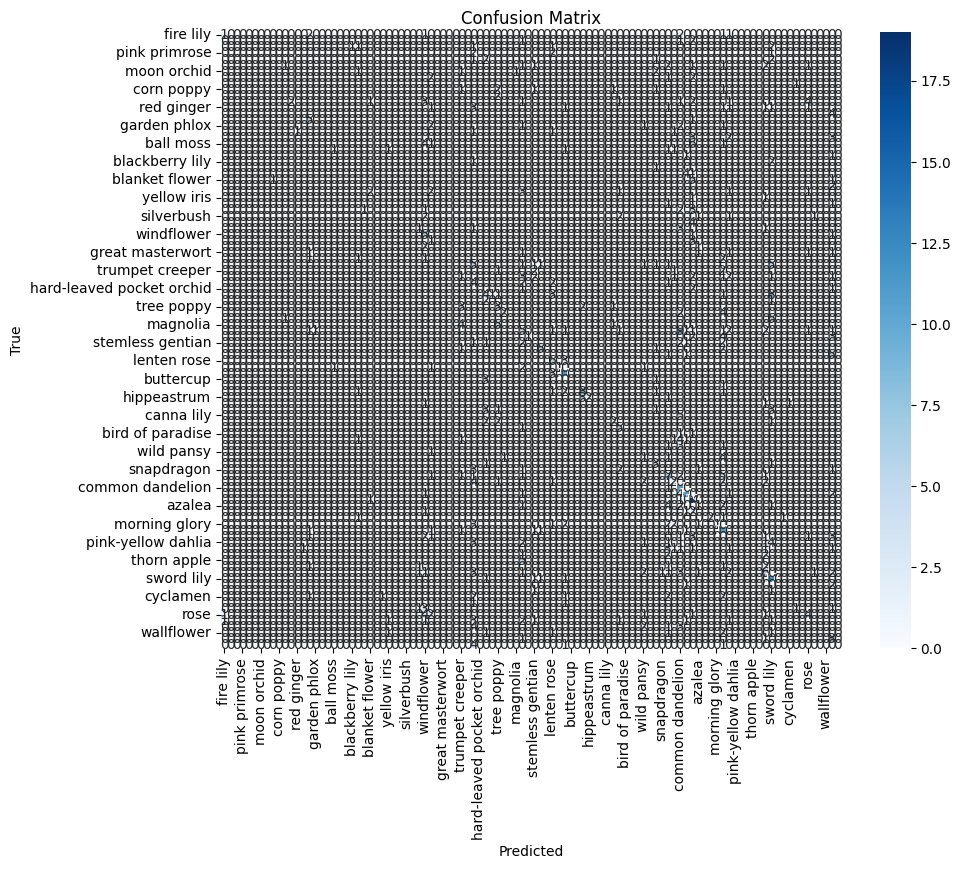

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Initialize variables to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation dataset to collect labels
with torch.no_grad():
    for images, labels in validloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Convert the confusion matrix to a Pandas DataFrame for visualization
cm_df = pd.DataFrame(cm, index=cat_to_name.values(), columns=cat_to_name.values())

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
writer.close()

In [ ]:
tensorboard --logdir=runs


SyntaxError: cannot assign to operator (721443724.py, line 1)